# Notebook to make a figure overviewing physical and numerical mixing integrated over the simulations as a function of wind stress 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

In [2]:
paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_001/shelf_dx_500_uwind_osc_001_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_002/shelf_dx_500_uwind_osc_002_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_004/shelf_dx_500_uwind_osc_004_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_008/shelf_dx_500_uwind_osc_008_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_01/shelf_dx_500_uwind_osc_01_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_02/shelf_dx_500_uwind_osc_02_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_04/shelf_dx_500_uwind_osc_04_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_08/shelf_dx_500_uwind_osc_08_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_09/shelf_dx_500_uwind_osc_09_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_1/shelf_dx_500_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_2/shelf_dx_500_uwind_osc_2_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_4/shelf_dx_500_uwind_osc_4_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_8/shelf_dx_500_uwind_osc_8_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_10/shelf_dx_500_uwind_osc_10_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_osc_10p5/shelf_dx_500_uwind_osc_10p5_avg.nc',]

def open_roms(path):
    ds = xroms.open_netcdf(path)
    ds, grid = xroms.roms_dataset(ds)
    return ds, grid

ds = []
grid = []
for i in range(len(paths)):
    dsa, grida = open_roms(paths[i])
    dsa['ocean_time'] = dsa.ocean_time[:]+timedelta(days=4) # Add 4 days to account for the change in initial condition 
    ds.append(dsa)
    grid.append(grida)
    
# Open the model basecase to examine the times for normalizing energy. Energy should be done with history files because 
# average files are outputted at the 30 minute mark, i.e., the along-shelf velocity != 0 at t = 30:00 only t = 0 . 
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_his.nc'
ds_base = xroms.open_netcdf(path1)
ds_base, grid_base = xroms.roms_dataset(ds_base)

In [3]:
time = np.arange(0,len(ds[0].ocean_time))/24 #Crude time vector, could do this a fancier way but meh. 
time+=5
print(time[0])
print(time[-1])
print(ds[0].ocean_time[0].values)
print(ds[0].ocean_time[-1].values)

5.0
21.958333333333332
0001-01-05 00:30:00
0001-01-21 23:30:00


In [4]:
# Open the files 
paths = ['/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_001_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_002_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_004_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_008_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_01_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_02_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_04_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_08_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_09_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_1_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_2_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_4_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_8_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_10_mix.nc',
         '/d2/home/dylan/idealized_nummix/diurnal_wind/outputs/mixing/shelf_dx_500_uwind_osc_10p5_mix.nc']
mix = []
for i in range(len(paths)):
    dso = xr.open_dataset(paths[i])
    dso['ocean_time'] = dso.ocean_time[:]+timedelta(days=4)
    mix.append(dso)

In [5]:
tslice = slice(120,241)
print(ds[0].isel(ocean_time = tslice).ocean_time[0].values)
print(ds[0].isel(ocean_time = tslice).ocean_time[-1].values)
#Double check mixing times line up with the model output just to be safe
print(mix[0].isel(ocean_time = tslice).ocean_time[0].values)
print(mix[0].isel(ocean_time = tslice).ocean_time[-1].values)

tslice1 = slice(60,241)
print(ds[0].isel(ocean_time = tslice1).ocean_time[0].values)
print(ds[0].isel(ocean_time = tslice1).ocean_time[-1].values)
#Double check mixing times line up with the model output just to be safe
print(mix[0].isel(ocean_time = tslice1).ocean_time[0].values)
print(mix[0].isel(ocean_time = tslice1).ocean_time[-1].values)

0001-01-10 00:30:00
0001-01-15 00:30:00
0001-01-10 00:30:00
0001-01-15 00:30:00
0001-01-07 12:30:00
0001-01-15 00:30:00
0001-01-07 12:30:00
0001-01-15 00:30:00


In [6]:
r = []
rextend = []
for i in range(len(paths)):
    ratio = mix[i].mnum_int.isel(ocean_time = tslice).sum().values/(mix[i].mphy_int.isel(ocean_time = tslice).sum().values)
    ratio1 = mix[i].mnum_int.isel(ocean_time = tslice1).sum().values/(mix[i].mphy_int.isel(ocean_time = tslice1).sum().values)
    r.append(ratio)
    rextend.append(ratio1)
r = np.array(r)
rextend = np.array(rextend)
print(r)
print(rextend)

[0.0575338  0.05759681 0.05831671 0.06104486 0.06483421 0.07210285
 0.11599512 0.14284993 0.15256766 0.15383979 0.11187313 0.06358762
 0.01785195 0.01324406 0.01246822]
[0.08026662 0.08039514 0.08123057 0.08410236 0.08757685 0.09732397
 0.13545155 0.15433701 0.16119774 0.16207264 0.11409205 0.0643519
 0.01554063 0.01123733 0.01081627]


In [7]:
tx = np.array([0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.09, 0.1, 0.2, 0.4, 0.8, 1, 1.5])

r11 = []
r12 = []
for i in range(len(paths)):
    ratio = mix[i].mnum_int.isel(ocean_time = tslice1).sum().values
    ratio1 = mix[i].mphy_int.isel(ocean_time = tslice1).sum().values
    r11.append(ratio)
    r12.append(ratio1)
r1 = np.array(r11)
r2 = np.array(r12)
print(r1)
print(r2)

[ 884800.75271054  885681.19683225  891042.64303628  920314.72510831
  957034.45750224 1048000.37923898 1593049.70507905 2560564.81645769
 2928676.90221116 3197632.14224249 3303058.87940029 2899539.85554329
  648566.97345041  428780.76048046  336187.77372967]
[11023271.69262047 11016601.8270698  10969301.23193134 10942793.6302583
 10927939.28020985 10768163.38595352 11761029.55548674 16590737.32794184
 18168226.09124087 19729623.58647351 28950823.79806442 45057561.13771234
 41733628.17824413 38156808.98596049 31081684.00192551]


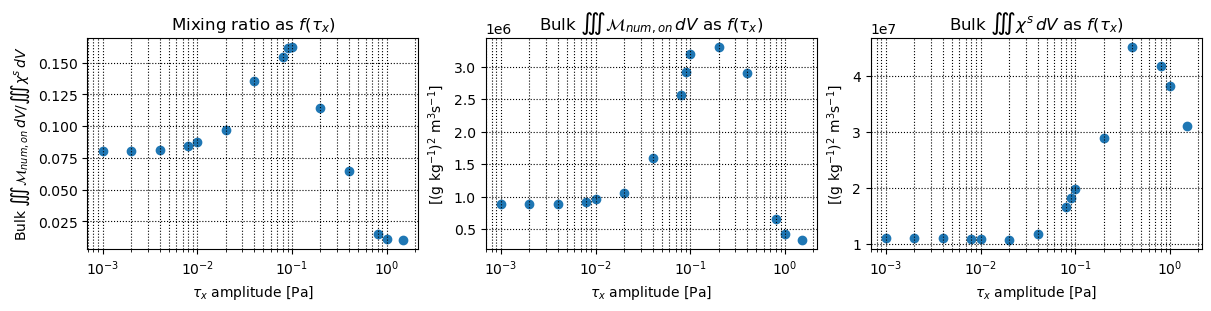

In [8]:
fig, ax = plt.subplots(1,3, figsize = (12,3), constrained_layout = True)

ax[0].scatter(tx,rextend)
ax[0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0].set_ylabel('Bulk $\iiint \mathcal{M}_{num,on} \, dV / \iiint \chi^s \, dV$')
ax[0].set_title(r'Mixing ratio as $f(\tau_x)$')

ax[1].scatter(tx,r1)
ax[1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[1].set_title(r'Bulk $\iiint \mathcal{M}_{num,on} \, dV$ as $f(\tau_x)$')

ax[2].scatter(tx,r2)
ax[2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[2].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[2].set_title(r'Bulk $\iiint \chi^s \, dV$ as $f(\tau_x)$')
ax[2].grid(which = 'both')
for i in range(3):
    ax[i].semilogx()
    ax[i].grid(which = 'both', ls = ':', c = 'k')
    # ax[i].semilogy()
# plt.savefig('mixing_function_taux')

In [9]:
s = np.load('../outputs/mean_shgrad_allsims_day7p5_15.npy')
sv = np.load('../outputs/mean_shvgrad_allsims_day7p5_15.npy')
diffu = np.load('../outputs/mean_sdfiffsuvity_allsims_day7pt_15.npy')
# diffu1 = np.load('../../mean_sdfiffsuvity_allsims_day10_15.npy')

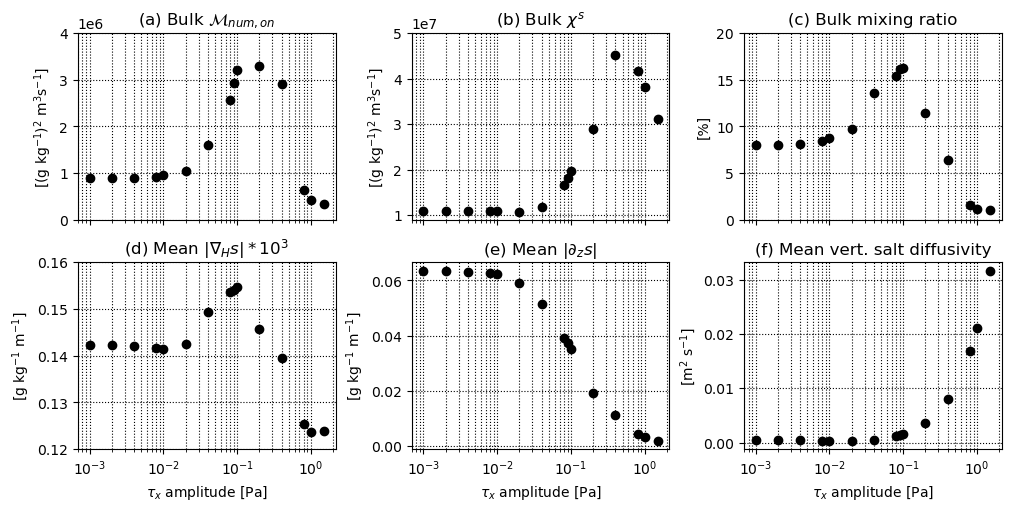

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].scatter(tx,r1, c = 'k')
# ax[0,0].semilogy()
ax[0,0].set_xlabel(r'')
ax[0,0].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,0].set_title(r'(a) Bulk $\mathcal{M}_{num,on}$')
ax[0,0].set_ylim(0, 4e6)


ax[0,1].scatter(tx, r2, c = 'k')
# ax[0,1].semilogy()
ax[0,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,1].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\chi^s$')
ax[0,1].set_ylim(0.9e7, 5e7)

ax[1,0].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,0].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,0].set_title(r'(d) Mean $|\nabla_H s|*10^3$')
ax[1,0].set_ylim(0.12, 0.16)

ax[1,1].scatter(tx, np.abs(sv), c = 'k')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\partial_z s|$')

ax[0,2].scatter(tx,np.array(rextend*100), c = 'k')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[%]')
ax[0,2].set_title(r'(c) Bulk mixing ratio')
ax[0,2].set_ylim(0,20)

ax[1,2].scatter(tx, diffu, c = 'k')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'[m$^2$ s$^{-1}$]')
ax[1,2].set_title(r'(f) Mean vert. salt diffusivity')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = ':', c = 'k')
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

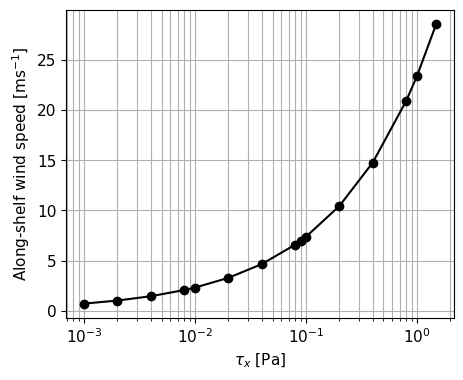

In [ ]:
tx = np.array([0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.09, 0.1, 0.2, 0.4, 0.8, 1, 1.5])
cd = 0.0015
rhoa = 1.225
u = np.sqrt(tx/(rhoa*cd))

plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(1, figsize = (5,4))

ax.semilogx(tx, u, color = 'k', marker = 'o')
# ax.plot(tx, u, marker = 'o')
ax.set_ylabel(r'Along-shelf wind speed [ms$^{-1}$]')
ax.set_xlabel(r'$\tau_x$ [Pa]')
ax.grid(which = 'both')
# plt.savefig('wind_stress_speed.jpg', dpi = 300, bbox_inches='tight')

# Now merge the two subplots 

Text(0.5, 0, '$\\tau_x$ amplitude [Pa]')

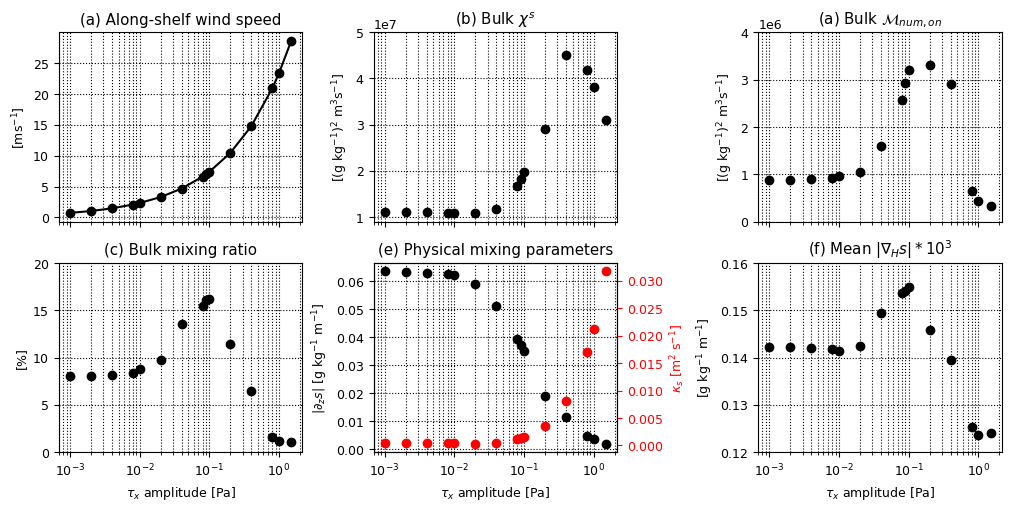

In [12]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Along-shelf wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')

ax[1,0].scatter(tx,np.array(rextend*100), c = 'k')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(c) Bulk mixing ratio')
ax[1,0].set_ylim(0,20)
ax[1,0].grid(which = 'both')

ax[0,1].scatter(tx, r2, c = 'k')
# ax[0,1].semilogy()
ax[0,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0,1].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\chi^s$')
ax[0,1].set_ylim(0.9e7, 5e7)

ax[0,2].scatter(tx,r1, c = 'k')
# ax[0,0].semilogy()
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(a) Bulk $\mathcal{M}_{num,on}$')
ax[0,2].set_ylim(0, 4e6)

ax[1,2].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,2].set_title(r'(f) Mean $|\nabla_H s|*10^3$')
ax[1,2].set_ylim(0.12, 0.16)

ax[1,1].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'$|\partial_z s|$ [g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Physical mixing parameters')

ax2 = ax[1,1].twinx()
ax2.scatter(tx, diffu, c = 'r', label = '')
ax2.set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax2.set_ylabel(r'$\kappa_s$ [m$^2$ s$^{-1}$]')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = ':', c = 'k')
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
# plt.savefig('mixing_function_taux.jpg', dpi = 300)

# Flip second and third columns. Spacing looks awkward as is because of the twin axes, 

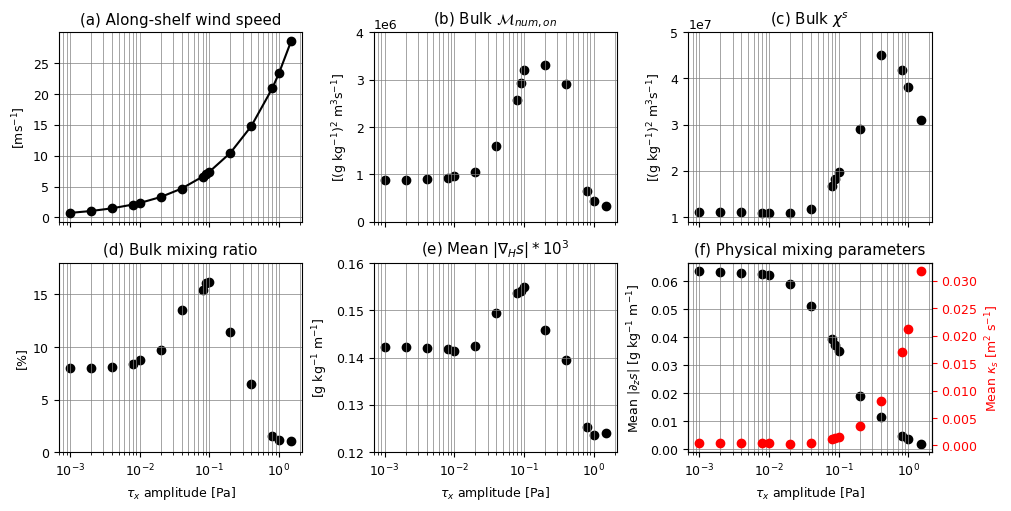

In [22]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(2,3, figsize = (10,5), constrained_layout = True)

ax[0,0].semilogx(tx, u, color = 'k', marker = 'o')
ax[0,0].set_ylabel(r'[ms$^{-1}$]')
ax[0,0].set_xlabel(r'$\tau_x$ [Pa]')
ax[0,0].grid(which = 'both')
ax[0,0].set_title('(a) Along-shelf wind speed')
ax[0,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')

ax[0,1].scatter(tx,r1, c = 'k')
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,1].set_title(r'(b) Bulk $\mathcal{M}_{num,on}$')
ax[0,1].set_ylim(0, 4e6)

ax[0,2].scatter(tx, r2, c = 'k')
ax[0,2].set_xlabel(r'')
ax[0,2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,2].set_title(r'(c) Bulk $\chi^s$')
ax[0,2].set_ylim(0.9e7, 5e7)

ax[1,0].scatter(tx,np.array(rextend*100), c = 'k')
ax[1,0].set_xlabel(r'')
ax[1,0].set_ylabel(r'[%]')
ax[1,0].set_title(r'(d) Bulk mixing ratio')
ax[1,0].set_ylim(0,18)
ax[1,0].grid(which = 'both')

ax[1,1].scatter(tx,np.array(s)*1000, c = 'k')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')
ax[1,1].set_title(r'(e) Mean $|\nabla_H s|*10^3$')
ax[1,1].set_ylim(0.12, 0.16)

ax[1,2].scatter(tx, np.abs(sv), c = 'k', label = '')
ax[1,2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,2].set_ylabel(r'Mean $|\partial_z s|$ [g kg$^{-1}$ m$^{-1}$]')
ax[1,2].set_title(r'(f) Physical mixing parameters')

ax2 = ax[1,2].twinx()
ax2.scatter(tx, diffu, c = 'r', label = '')
ax2.set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax2.set_ylabel(r'Mean $\kappa_s$ [m$^2$ s$^{-1}$]')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')

for i in range(2):
    for j in range(3):
        ax[i,j].semilogx()
        ax[0,j].set_xticklabels('')
        # ax[i,j].semilogy(base = 2)
        ax[0,i].set_xlabel('')
        ax[i,j].grid(which = 'both', ls = '-', c = 'grey', lw = 0.5)
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
plt.savefig('mixing_function_taux.jpg', dpi = 300)